In [2]:
import pandas as pd
import numpy as np
import re
from konlpy.tag import Okt
from collections import Counter
import pickle
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel
import scipy.sparse as sp
import scipy

import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'pandas'

In [162]:
#아고다 전처리
agoda = pd.read_csv("agoda_review.csv")
agoda.drop(['Unnamed: 0'], axis=1, inplace=True)
agoda = agoda[['title', 'score', 'text', 'date']]
agoda.columns = ['hotel', 'star', 'review', 'real_date']

In [163]:
# 야놀자 전처리
yanolja = pd.read_csv("야놀자_최종.csv")
yanolja.drop(['date'], axis=1, inplace=True)
#10점 만점으로 변경
yanolja['star'] = yanolja['star'].astype(int)
yanolja['star'] = yanolja['star'] * 2
# 숫자만 남기기
yanolja['real_date'] = yanolja['real_date'].replace(r'[^0-9]', '', regex=True)
yanolja['real_date'] = yanolja['real_date'].astype(int)

In [164]:
# 여기어때 전처리
here = pd.read_csv("여기어때_review.csv")
# date 수정 : 개월, 년, 일, 시간
# 기준일 : 6월 4일
here['real_date'] = np.nan

for i,j in enumerate(here['date']):
    if "시간" in j:
        here.loc[i, 'real_date'] = 20230604
    elif "일" in j:
        day = int(j.split("일")[0])
        if day < 4: #6월에 작성
            here.loc[i, 'real_date'] = 20230604-day
        else: #5월에 작성
            day = day - 4
            here.loc[i, 'real_date'] = 20230531-day
    elif "개월" in j:
        month = int(j.split('개월')[0])
        if month < 6: #2023년에 작성
            here.loc[i, 'real_date'] = 20230604-(month * 100)
        else: #2022년에 작성
            month = month - 6
            here.loc[i, 'real_date'] = 20221204-(month * 100)
    elif "년" in j:
        year = int(j.split('년')[0])
        if year < 4: # 2020년 ~
            here.loc[i, 'real_date'] = 20230604-(year * 10000)
        else: # ~ 2019년
            year = year - 4
            here.loc[i, 'real_date'] = 20190604-(year * 10000)
here['real_date'] = here['real_date'].astype(int)
here.drop(['date'], axis=1, inplace=True)


In [165]:
# 플랫폼 합치기
df = pd.concat([agoda, yanolja, here])
# 2020년 6월 4일 이후 리뷰만
df = df[df['real_date'] >= 20200604].reset_index(drop=True)
#한글 및 공백만 남기기
df['review'] = df['review'].replace(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)
# 리뷰에 텍스트가 남아있지 않은 경우 삭제
df = df[df['review'] != ''].reset_index(drop=True)

In [64]:
df['review clean'] = np.nan

for i,j in enumerate(df['review']):
    tokenizer = Okt()

    #1글자 단어 제외하고 명사만 남기기
    new_k = list()
    for w in tokenizer.nouns(j):
        if (len(w) != 1):
            new_k.append(w)
    
    # (상위 100개 빈도수 돌렸을 때) 불용어 제거
#     stop_word = ['이용','사장', '숙소', '마을','전주','다음','정말','보기','여행','예약','항상','최고','생각'
#                  '진짜','조금','아주','여기','장소','다시','정도','추천','바로','대비','매우','숙박'
#                 '처음','하나','완전','자주','그냥','다만','덕분','다른','하루','주인','체크','무엇',
#                 '전체','가면','부분','가면','저희']
            
    token = [t for t in new_k ] #if t not in stop_word
    text = ' '.join(token)


    df.loc[i, 'review clean'] = text

df.to_csv("review clean1.csv",index=False, encoding="utf-8-sig")

In [2]:
df = pd.read_csv("review clean1.csv")
df = df.dropna(subset=['review clean']) #공백이 NaN으로 저장되므로 추후 분석에서 필요없어 dropna로 삭제
df

,hotel,star,review,real_date,review clean
0,전주 중화산동 Q (Jeonju Junghwasan-dong Q),8.4,사람이많아지고 뭔가 덜청결해지고 좀 부산해진느낌주인분은친절하고조아요,20220821,사람 뭔가 느낌 주인
1,전주 신시가지 오스카 (Jeonju Sinsigaji Oscar),4.4,담배낸새가 넘 많이나여,20230123,담배
2,전주 신시가지 오스카 (Jeonju Sinsigaji Oscar),6.8,생각보다 깔끔합니다 단지 난방이 없고 전기장판으로 버텨야합니다 아참 불을 다꺼도 예...,20230111,생각 단지 난방 전기장판 신분 절대 불빛 침대 한가운데 첮장 침대 머리
4,전주 중화산동 알프스 (Jeonju Junghwadong Alps),6.0,방음이 잘 안되서 아쉬웠어요,20230529,방음
6,전주 중화산동 알프스 (Jeonju Junghwadong Alps),6.0,옛날 여관느낌,20230513,옛날 여관 느낌
...,...,...,...,...,...
22633,전주 신시가지 오스카,1.0,지금까지 가본곳중 최악침대보이불보는 언제 갈았는지 새벽에 몸이 하도 간지러워서 계속...,20230304,지금 최악 침대보 불보 언제 새벽 계속 벌레 계속 느낌 화장실 기타 가구 샤워 곰팡...
22634,전주 신시가지 오스카,2.0,시퇴실인데 시좀 지나서 전화소리가 들렸는데피곤해서 못받았습니다 그럼 다시 전화를 주...,20230304,퇴실 전화소 리가 다시 전화 주변 업체 새벽 이해 아줌마 업체 추가 요금 번은 방문
22635,전주 신시가지 오스카,10.0,건물 객실 전부 청결해서 좋아요 객실도 욕실도 넓고 깨끗해요 침대는 스프링이 좀 덜...,20230304,건물 객실 전부 객실 욕실 침대 스프링 거리 가격 가성 쉬기 정말
22636,전주 신시가지 오스카,10.0,사장님도 친절하시구 시설도 쾌적하고 너무 좋았어용화장실도 쾌적하고 엄청 큰 욕조도 ...,20230204,사장 시설 화장실 욕조 기도


In [72]:
word_list = list()

for t in df['review clean']:
    word_list.append(t.split(" "))
word_list = sum(word_list, []) 
len(word_list)

126056

In [73]:
c = Counter(word_list)
word_dict = dict(c.most_common(100)) #상위 100개만
word_dict

{'사장': 3447,
 '숙소': 2536,
 '이용': 1929,
 '마을': 1771,
 '전주': 1658,
 '다음': 1487,
 '정말': 1411,
 '시설': 1356,
 '보기': 1333,
 '화장실': 1330,
 '가격': 1314,
 '방문': 1225,
 '위치': 1168,
 '조식': 1082,
 '방도': 1080,
 '여행': 1030,
 '가성': 967,
 '객실': 952,
 '냄새': 913,
 '예약': 844,
 '침대': 826,
 '항상': 763,
 '최고': 758,
 '생각': 743,
 '방이': 741,
 '진짜': 724,
 '조금': 700,
 '아주': 687,
 '주차': 668,
 '방음': 659,
 '여기': 641,
 '주차장': 598,
 '청소': 573,
 '다시': 563,
 '시간': 556,
 '정도': 556,
 '추천': 552,
 '직원': 529,
 '청결': 527,
 '주변': 527,
 '바로': 525,
 '사진': 522,
 '침구': 520,
 '아침': 505,
 '호텔': 496,
 '담배': 490,
 '대비': 479,
 '매우': 477,
 '숙박': 472,
 '처음': 467,
 '상태': 457,
 '기분': 455,
 '소리': 435,
 '출장': 435,
 '하나': 427,
 '모텔': 425,
 '완전': 418,
 '자주': 418,
 '그냥': 416,
 '바닥': 411,
 '근처': 394,
 '수건': 392,
 '거리': 391,
 '후기': 375,
 '다만': 375,
 '덕분': 361,
 '욕실': 359,
 '이불': 356,
 '느낌': 354,
 '욕조': 353,
 '서비스': 352,
 '다른': 351,
 '접근성': 350,
 '하루': 342,
 '컨디션': 337,
 '사용': 335,
 '친절': 333,
 '주인': 328,
 '샤워': 322,
 '의사': 305,
 '체크': 301,
 '무엇': 

# LSI 분석

In [3]:
#corpus로 딕셔너리 만들기
corpus = df['review clean'].str.split()
dictionary = corpora.Dictionary(corpus)
bow = [dictionary.doc2bow(text) for text in corpus]

Coherence score with 2 clusters: 0.5306211899778527
Coherence score with 3 clusters: 0.6482401590430333
Coherence score with 4 clusters: 0.5224087893033714
Coherence score with 5 clusters: 0.5028923982667612
Coherence score with 6 clusters: 0.5108838476046281
Coherence score with 7 clusters: 0.5035169478775126
Coherence score with 8 clusters: 0.5922278911167564
Coherence score with 9 clusters: 0.6267371585300751
Coherence score with 10 clusters: 0.6022649490199765


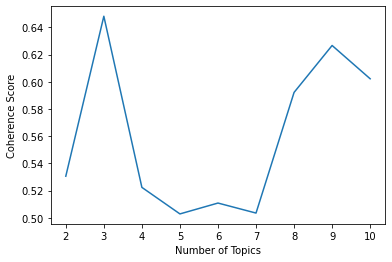

In [4]:
# 최적의 topic 수를 찾기 위해 topic에 대해 일관성 점수 비교
coherence_scores = []
num_topics_range = range(2, 11)

for i in num_topics_range:
    lsi = LsiModel(bow, num_topics=i, id2word=dictionary)
    coherence_model = CoherenceModel(model=lsi, texts=corpus, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)
    
    print('Coherence score with {} clusters: {}'.format(i, coherence_score))

plt.plot(num_topics_range, coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show()

topic 수가 3개일 때 일관성 점수가 가장 높음

In [16]:
#SVD
lsi = LsiModel(bow, num_topics=3, id2word=dictionary)


In [17]:
for topic_num, words in lsi.print_topics(num_words=5):
    print('Words in {}: {}.'.format(topic_num, words))

Words in 0: 0.594*"사장" + 0.506*"항상" + 0.345*"친절" + 0.333*"컨지션" + 0.208*"이용".
Words in 1: 0.807*"다음" + -0.265*"항상" + 0.191*"사장" + -0.190*"컨디션" + -0.183*"객실".
Words in 2: 0.495*"이용" + 0.411*"객실" + 0.394*"다음" + -0.391*"사장" + 0.372*"컨디션".


계수가 높을수록 그 단어가 주제와 연관있음을 의미함

In [43]:
topic_data = []

for topic_num, words in lsi.print_topics(num_words=5):
    topic_words = [word.split('*')[1].strip() for word in words.split(' + ')]
    topic_coefs = [float(word.split('*')[0]) for word in words.split(' + ')]
    sorted_topic = sorted(zip(topic_words, topic_coefs), key=lambda x: x[1], reverse=True)
    sorted_topic_words, sorted_topic_coefs = zip(*sorted_topic)
    topic_data.append({'Topic': topic_num, 'Words': sorted_topic_words, 'Coefficients': sorted_topic_coefs})


review_total = pd.DataFrame(topic_data)
review_total

,Topic,Words,Coefficients
0,0,"(""사장"", ""항상"", ""친절"", ""컨지션"", ""이용"")","(0.594, 0.506, 0.345, 0.333, 0.208)"
1,1,"(""다음"", ""사장"", ""객실"", ""컨디션"", ""항상"")","(0.807, 0.191, -0.183, -0.19, -0.265)"
2,2,"(""이용"", ""객실"", ""다음"", ""컨디션"", ""사장"")","(0.495, 0.411, 0.394, 0.372, -0.391)"


In [24]:
lsimodel = LsiModel(corpus=bow, num_topics=3, id2word=dictionary)

In [25]:
# U-matrix
u_df = pd.DataFrame(data= lsimodel.projection.u)
u_df.sort_values(axis= 0, by= 0, ascending= False)

,0,1,2
23,5.936985e-01,-1.908803e-01,-3.905610e-01
155,5.063028e-01,2.647318e-01,1.870485e-01
24,3.447638e-01,4.997731e-02,-1.985873e-01
7844,3.325601e-01,5.733444e-02,-1.951971e-01
83,2.081956e-01,1.781734e-01,4.952542e-01
...,...,...,...
4220,-5.429945e-09,1.446060e-09,1.124501e-08
3004,-1.191722e-08,3.169891e-09,2.467802e-08
752,-3.384935e-08,3.925783e-08,-3.207378e-09
7424,-1.196108e-07,1.281882e-07,1.110677e-07


23, 155, 24, 7844는 topic0 과 가장 연관있고 83는 topic2와 가장 연관 있음을 알 수 있음


In [26]:
#S-matirx
s_df = pd.DataFrame(data= lsimodel.projection.s)
s_df

,0
0,147.954528
1,113.766804
2,111.953861


topic 수를 3개로 지정했으므로 3개의 특이값이 생김.
topic의 중요도에 따라 순위를 매기므로 topic 0이 가장 중요하며 topic 2가 가장 중요하지 않음을 알 수 있음.

In [29]:
#리뷰의 topic 별 할당 점수 비교
corpus_lsi = lsi[bow]

score1 = []
score2 = []
score3 = []


for doc in corpus_lsi:
    if len(doc) > 0: 
        score1.append(round(doc[0][1], 2))
        if len(doc) > 1:
            score2.append(round(doc[1][1], 2))
        else:
            score2.append(0)
        if len(doc) > 2:
            score3.append(round(doc[2][1], 2))
        else:
            score3.append(0)
    else:  
        score1.append(0)
        score2.append(0)
        score3.append(0)

        
        
#각 리뷰가 어떤 topic에 가장 연관있는지 보여주기
df_topic = pd.DataFrame()
df_topic['date'] = df['real_date']
df_topic['Text'] = df['review']
df_topic['Topic 0 score'] = score1
df_topic['Topic 1 score'] = score2
df_topic['Topic 2 score'] = score3

df_topic['Topic'] = df_topic.iloc[:, 2:].idxmax(axis=1)
df_topic

,date,Text,Topic 0 score,Topic 1 score,Topic 2 score,Topic
0,20220821,사람이많아지고 뭔가 덜청결해지고 좀 부산해진느낌주인분은친절하고조아요,0.03,0.04,0.01,Topic 1 score
1,20230123,담배낸새가 넘 많이나여,0.01,0.01,0.01,Topic 0 score
2,20230111,생각보다 깔끔합니다 단지 난방이 없고 전기장판으로 버텨야합니다 아참 불을 다꺼도 예...,0.07,0.10,0.05,Topic 1 score
4,20230529,방음이 잘 안되서 아쉬웠어요,0.01,0.02,0.00,Topic 1 score
6,20230513,옛날 여관느낌,0.01,0.02,0.00,Topic 1 score
...,...,...,...,...,...,...
22633,20230304,지금까지 가본곳중 최악침대보이불보는 언제 갈았는지 새벽에 몸이 하도 간지러워서 계속...,0.20,0.97,0.46,Topic 1 score
22634,20230304,시퇴실인데 시좀 지나서 전화소리가 들렸는데피곤해서 못받았습니다 그럼 다시 전화를 주...,0.09,0.15,0.05,Topic 1 score
22635,20230304,건물 객실 전부 청결해서 좋아요 객실도 욕실도 넓고 깨끗해요 침대는 스프링이 좀 덜...,0.47,-0.17,0.89,Topic 2 score
22636,20230204,사장님도 친절하시구 시설도 쾌적하고 너무 좋았어용화장실도 쾌적하고 엄청 큰 욕조도 ...,0.66,0.28,-0.34,Topic 0 score


In [35]:
topic_counts = df_topic['Topic'].value_counts()
topic_counts

Topic
Topic 1 score    8434
Topic 0 score    6160
Topic 2 score    1723
Name: count, dtype: int64

In [39]:
topic_ratios = round(topic_counts / sum(topic_counts) * 100,2)
topic_ratios

Topic
Topic 1 score    51.69
Topic 0 score    37.75
Topic 2 score    10.56
Name: count, dtype: float64

In [44]:
review_total['topic_ratios(%)'] = [37.75, 51.69, 10.56]
review_total

,Topic,Words,Coefficients,topic_ratios(%)
0,0,"(""사장"", ""항상"", ""친절"", ""컨지션"", ""이용"")","(0.594, 0.506, 0.345, 0.333, 0.208)",37.75
1,1,"(""다음"", ""사장"", ""객실"", ""컨디션"", ""항상"")","(0.807, 0.191, -0.183, -0.19, -0.265)",51.69
2,2,"(""이용"", ""객실"", ""다음"", ""컨디션"", ""사장"")","(0.495, 0.411, 0.394, 0.372, -0.391)",10.56


# 20-21년도 / 21-22년도 / 22-23년도로 기준을 나눠 시계열 비교

In [45]:
df_2021 = df[(df['real_date'] >= 20200604) & (df['real_date'] < 20210604)].reset_index(drop=True)
df_2122 = df[(df['real_date'] >= 20210604) & (df['real_date'] < 20220604)].reset_index(drop=True)
df_2223 = df[(df['real_date'] >= 20220604) & (df['real_date'] < 20230605)].reset_index(drop=True)

In [46]:
df_2021

,hotel,star,review,real_date,review clean
0,전주 중앙동 라온 호텔 (Jeonju Jungang Raon Hotel),5.2,욕실은 크고 좋았습니다침구류도 푹신합니다거리도 여행지랑 가까운편입니다 한옥마을까지 ...,20210526,욕실 침구 거리 여행지 편입 마을 도보 정도 금은 여름 난방 프론트 부탁 응대 해주...
1,전주 여지 게스트하우스 (Jeonju Yeoji Guest House),9.6,제가 영화제 바쁘게 돌아다니느라 얼굴도 못 뵈었고 통화도 어려웠지만 문자로도 친절하...,20210512,영화제 얼굴 통화 자로 응대 방도 업그레이드 해주시 캐리어 덕분 전주 영화제
2,전주한옥마을 홍시 게스트하우스 (Jeonju Hanok Village Hongsi ...,10.0,앵두방 예약했는데 은행방으로 업그레이드해주셔서 편히 쉬다왔습니다다음에 또 갈게요,20200729,앵두 예약 은행 업그레이드 다음
3,전주한옥마을 홍시 게스트하우스 (Jeonju Hanok Village Hongsi ...,10.0,사실 한옥보단 옛날 할머니집 간같은 느낌이 많이나요 ㅎㅎ,20201122,사실 옥보단 옛날 할머니 느낌
4,전주 중화산동 MH HOTEL 중화산점 (Jeonju Junghwasan-dong ...,10.0,가격도 착하고 스타일러도 있어서 편하게 쉬기 좋아요,20210517,가격 스타
...,...,...,...,...,...
1719,전주 한옥마을 어린왕자 게스트하우스,10.0,세아들과함께갔는데 정말깨끗합니다화장실에 굉장히 민감한편인데 진짜 정말깨끗합니다주인분...,20200604,아들 정말 화장실 민감 한편 진짜 정말 주인 진짜 호텔 직원 요조 거실 테이블 식빵...
1720,전주 한옥마을 어린왕자 게스트하우스,10.0,아이들에게 게스트하우스 경험해주고 싶어서 방문했어요처음이었지만 아이들하고 여행을 많...,20200604,아이 게스트하우스 경험 방문 처음 아이 여행 숙소 꼽아 화장실 물때 깨끗 이불 호텔...
1721,전주 한옥마을 어린왕자 게스트하우스,10.0,생각보다 너무 예쁜게스트하우스운영하시는분도 너무 이쁘신 언니가 친절하게 안내 설명 ...,20200604,생각 게스트하우스 운영 분도 언니 안내 설명 해주시 개인 화장실 냉장고 언제 간식 ...
1722,전주 한옥마을 어린왕자 게스트하우스,10.0,지난주말에 묵었는데 체크인 시간이 늦어 사장님 얼굴을 못뵈었지만 통화로 너무너무 친...,20200604,주말 체크 시간 사장 얼굴 통화 주차 세심 신경 느낌 시설 신축 정돈 느낌 곳곳 포...


In [47]:
corpus_2021 = df_2021['review clean'].str.split()
dictionary_2021 = corpora.Dictionary(corpus_2021)
bow_2021 = [dictionary_2021.doc2bow(text) for text in corpus_2021]

Coherence score with 2 clusters: 0.6169897097555281
Coherence score with 3 clusters: 0.6474945292777389
Coherence score with 4 clusters: 0.6195739799456788
Coherence score with 5 clusters: 0.5758625199375461
Coherence score with 6 clusters: 0.6181614243518355
Coherence score with 7 clusters: 0.5812408106655494
Coherence score with 8 clusters: 0.5898808486866894
Coherence score with 9 clusters: 0.560300369363625
Coherence score with 10 clusters: 0.5738811261656509


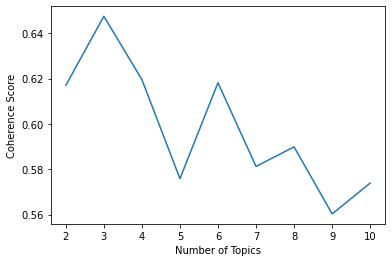

In [48]:
coherence_scores_2021 = []
num_topics_range = range(2, 11)

for i in num_topics_range:
    lsi = LsiModel(bow_2021, num_topics=i, id2word=dictionary_2021)
    coherence_model = CoherenceModel(model=lsi, texts=corpus_2021, dictionary=dictionary_2021, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores_2021.append(coherence_score)
    
    print('Coherence score with {} clusters: {}'.format(i, coherence_score))

plt.plot(num_topics_range, coherence_scores_2021)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show()

In [49]:
lsi_2021 = LsiModel(bow_2021, num_topics=3, id2word=dictionary_2021)

In [58]:
topic_data_2021 = []

for topic_num, words in lsi_2021.print_topics(num_words=5):
    topic_words_2021 = [word.split('*')[1].strip() for word in words.split(' + ')]
    topic_coefs_2021 = [float(word.split('*')[0]) for word in words.split(' + ')]
    sorted_topic_2021 = sorted(zip(topic_words_2021, topic_coefs_2021), key=lambda x: x[1], reverse=True)
    sorted_topic_words_2021, sorted_topic_coefs_2021 = zip(*sorted_topic_2021)
    topic_data_2021.append({'2021Words': sorted_topic_words_2021, '2021Coefficients': sorted_topic_coefs_2021})


df_2021_words = pd.DataFrame(topic_data_2021)
df_2021_words

,2021Words,2021Coefficients
0,"(""사장"", ""숙소"", ""마을"", ""보기"", ""정말"")","(0.44, 0.362, 0.297, 0.259, 0.23)"
1,"(""소리"", ""커튼"", ""바로"", ""담배"", ""사장"")","(0.256, 0.228, 0.209, 0.201, -0.331)"
2,"(""숙소"", ""마을"", ""정말"", ""방도"", ""사장"")","(0.619, 0.247, -0.12, -0.137, -0.613)"


In [51]:
corpus_2122 = df_2122['review clean'].str.split()
dictionary_2122 = corpora.Dictionary(corpus_2122)
bow_2122 = [dictionary_2122.doc2bow(text) for text in corpus_2122]

Coherence score with 2 clusters: 0.5542959167158257
Coherence score with 3 clusters: 0.5943513215470829
Coherence score with 4 clusters: 0.5206279196038494
Coherence score with 5 clusters: 0.6135940532392082
Coherence score with 6 clusters: 0.6970215844776447
Coherence score with 7 clusters: 0.6620244115924516
Coherence score with 8 clusters: 0.5984050193807281
Coherence score with 9 clusters: 0.6030390757686198
Coherence score with 10 clusters: 0.6609159965092857


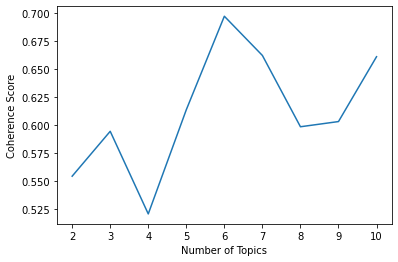

In [52]:
coherence_scores_2122 = []
num_topics_range = range(2, 11)

for i in num_topics_range:
    lsi = LsiModel(bow_2122, num_topics=i, id2word=dictionary_2122)
    coherence_model = CoherenceModel(model=lsi, texts=corpus_2122, dictionary=dictionary_2122, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores_2122.append(coherence_score)
    
    print('Coherence score with {} clusters: {}'.format(i, coherence_score))

plt.plot(num_topics_range, coherence_scores_2122)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show()

In [54]:
lsi_2122 = LsiModel(bow_2122, num_topics=6, id2word=dictionary_2122)

In [59]:
topic_data_2122 = []

for topic_num, words in lsi_2122.print_topics(num_words=5):
    topic_words_2122 = [word.split('*')[1].strip() for word in words.split(' + ')]
    topic_coefs_2122 = [float(word.split('*')[0]) for word in words.split(' + ')]
    sorted_topic_2122 = sorted(zip(topic_words_2122, topic_coefs_2122), key=lambda x: x[1], reverse=True)
    sorted_topic_words_2122, sorted_topic_coefs_2122 = zip(*sorted_topic_2122)
    topic_data_2122.append({'2122Words': sorted_topic_words_2122, '2122Coefficients': sorted_topic_coefs_2122})


df_2122_words = pd.DataFrame(topic_data_2122)
df_2122_words

,2122Words,2122Coefficients
0,"(""사장"", ""숙소"", ""마을"", ""보기"", ""전주"")","(0.51, 0.402, 0.247, 0.229, 0.206)"
1,"(""사장"", ""예약"", ""냄새"", ""보기"", ""숙소"")","(0.731, -0.123, -0.128, -0.134, -0.445)"
2,"(""화장실"", ""보기"", ""냄새"", ""시간"", ""숙소"")","(0.216, 0.174, 0.152, 0.15, -0.676)"
3,"(""숙소"", ""다음"", ""여행"", ""마을"", ""전주"")","(0.251, -0.289, -0.293, -0.389, -0.486)"
4,"(""마을"", ""위치"", ""예약"", ""다음"", ""전주"")","(0.644, 0.335, -0.147, -0.204, -0.392)"
5,"(""정말"", ""조식"", ""진짜"", ""화장실"", ""사장"")","(0.771, 0.228, -0.153, -0.208, -0.241)"


In [56]:
corpus_2223 = df_2223['review clean'].str.split()
dictionary_2223 = corpora.Dictionary(corpus_2223)
bow_2223 = [dictionary_2223.doc2bow(text) for text in corpus_2223]

Coherence score with 2 clusters: 0.5534946457581194
Coherence score with 3 clusters: 0.5537263424215102
Coherence score with 4 clusters: 0.5262691935683146
Coherence score with 5 clusters: 0.5010643250382087
Coherence score with 6 clusters: 0.5756970779431891
Coherence score with 7 clusters: 0.5537815763937469
Coherence score with 8 clusters: 0.5022218095635808
Coherence score with 9 clusters: 0.5739126559641784
Coherence score with 10 clusters: 0.5693980126722461


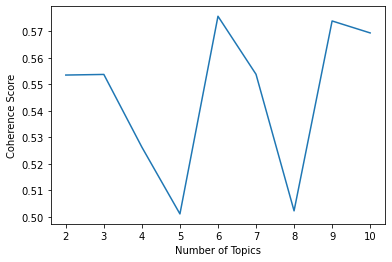

In [57]:
coherence_scores_2223 = []
num_topics_range = range(2, 11)

for i in num_topics_range:
    lsi = LsiModel(bow_2223, num_topics=i, id2word=dictionary_2223)
    coherence_model = CoherenceModel(model=lsi, texts=corpus_2223, dictionary=dictionary_2223, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores_2223.append(coherence_score)
    
    print('Coherence score with {} clusters: {}'.format(i, coherence_score))

plt.plot(num_topics_range, coherence_scores_2223)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show()

In [60]:
lsi_2223 = LsiModel(bow_2223, num_topics=6, id2word=dictionary_2223)

In [63]:
topic_data_2223 = []

for topic_num, words in lsi_2223.print_topics(num_words=5):
    topic_words_2223 = [word.split('*')[1].strip() for word in words.split(' + ')]
    topic_coefs_2223 = [float(word.split('*')[0]) for word in words.split(' + ')]
    sorted_topic_2223 = sorted(zip(topic_words_2223, topic_coefs_2223), key=lambda x: x[1], reverse=True)
    sorted_topic_words_2223, sorted_topic_coefs_2223 = zip(*sorted_topic_2223)
    topic_data_2223.append({'2223Words': sorted_topic_words_2223, '2223Coefficients': sorted_topic_coefs_2223})


df_2223_words = pd.DataFrame(topic_data_2223)
df_2223_words

,2223Words,2223Coefficients
0,"(""항상"", ""사장"", ""친절"", ""컨지션"", ""이용"")","(0.555, 0.54, 0.368, 0.361, 0.216)"
1,"(""사장"", ""다음"", ""컨디션"", ""객실"", ""이용"")","(0.408, -0.229, -0.408, -0.439, -0.513)"
2,"(""다음"", ""사장"", ""객실"", ""컨디션"", ""항상"")","(0.957, 0.116, -0.109, -0.111, -0.119)"
3,"(""방이"", ""숙소"", ""사장"", ""항상"", ""컨지션"")","(0.373, 0.337, 0.328, -0.263, -0.265)"
4,"(""청결"", ""장판"", ""숙소"", ""사장"", ""방이"")","(0.592, 0.535, 0.199, -0.196, -0.369)"
5,"(""숙소"", ""사장"", ""장판"", ""청결"", ""방이"")","(0.331, -0.206, -0.419, -0.423, -0.441)"


In [64]:
df_words = pd.concat([df_2021_words,df_2122_words,df_2223_words],axis=1)
df_words

,2021Words,2021Coefficients,2122Words,2122Coefficients,2223Words,2223Coefficients
0,"(""사장"", ""숙소"", ""마을"", ""보기"", ""정말"")","(0.44, 0.362, 0.297, 0.259, 0.23)","(""사장"", ""숙소"", ""마을"", ""보기"", ""전주"")","(0.51, 0.402, 0.247, 0.229, 0.206)","(""항상"", ""사장"", ""친절"", ""컨지션"", ""이용"")","(0.555, 0.54, 0.368, 0.361, 0.216)"
1,"(""소리"", ""커튼"", ""바로"", ""담배"", ""사장"")","(0.256, 0.228, 0.209, 0.201, -0.331)","(""사장"", ""예약"", ""냄새"", ""보기"", ""숙소"")","(0.731, -0.123, -0.128, -0.134, -0.445)","(""사장"", ""다음"", ""컨디션"", ""객실"", ""이용"")","(0.408, -0.229, -0.408, -0.439, -0.513)"
2,"(""숙소"", ""마을"", ""정말"", ""방도"", ""사장"")","(0.619, 0.247, -0.12, -0.137, -0.613)","(""화장실"", ""보기"", ""냄새"", ""시간"", ""숙소"")","(0.216, 0.174, 0.152, 0.15, -0.676)","(""다음"", ""사장"", ""객실"", ""컨디션"", ""항상"")","(0.957, 0.116, -0.109, -0.111, -0.119)"
3,NaN,NaN,"(""숙소"", ""다음"", ""여행"", ""마을"", ""전주"")","(0.251, -0.289, -0.293, -0.389, -0.486)","(""방이"", ""숙소"", ""사장"", ""항상"", ""컨지션"")","(0.373, 0.337, 0.328, -0.263, -0.265)"
4,NaN,NaN,"(""마을"", ""위치"", ""예약"", ""다음"", ""전주"")","(0.644, 0.335, -0.147, -0.204, -0.392)","(""청결"", ""장판"", ""숙소"", ""사장"", ""방이"")","(0.592, 0.535, 0.199, -0.196, -0.369)"
5,NaN,NaN,"(""정말"", ""조식"", ""진짜"", ""화장실"", ""사장"")","(0.771, 0.228, -0.153, -0.208, -0.241)","(""숙소"", ""사장"", ""장판"", ""청결"", ""방이"")","(0.331, -0.206, -0.419, -0.423, -0.441)"


# 리뷰 많은 (100개 이상) 숙소에 대해 토픽 모델링

In [65]:
review_counts = df.groupby('hotel')['review clean'].count().reset_index()
review_counts = review_counts.sort_values(by='review clean', ascending=False)
review_counts = review_counts[(review_counts['review clean'] >= 100)].reset_index(drop=True)
review_counts

,hotel,review clean
0,전주 중화산동 라베호텔(LABE HOTEL) (Jeonju Junghwasandon...,131
1,전주 금암동 베스트인시티 호텔,119
2,전주 중화산동 엘도라도,118
3,전주 고사동 YAJA 전주한옥마을점,118
4,전주 금암동 블루원,114
5,전주 우아동 호텔 믹스(MIX),113
6,전주 산정동 칸,113
7,전주 우아동 호텔 젠,112
8,전주 중화산동 프린스,111
9,전주 신시가지 오스카,106


In [66]:
hotel_list = review_counts['hotel'].tolist()
new_df = df[df['hotel'].isin(hotel_list)]
new_df

,hotel,star,review,real_date,review clean
188,전주 중화산동 라베호텔(LABE HOTEL) (Jeonju Junghwasandon...,6.0,깨끗하고 괜찮은데 개인적으로는 침대가 너무 푹신해서 잘 안맞음,20230420,개인 침대
189,전주 중화산동 라베호텔(LABE HOTEL) (Jeonju Junghwasandon...,10.0,잘 쉬고 갑니다직원분 너무 친절합니다베개가 한개라 안고잘 여분이 없어서 아쉬웠지만 ...,20230324,직원 베개 여분
190,전주 중화산동 라베호텔(LABE HOTEL) (Jeonju Junghwasandon...,10.0,가족과 내집처럼펀하게 이용하고 왔습니다감사합니다,20230102,가족 이용
191,전주 중화산동 라베호텔(LABE HOTEL) (Jeonju Junghwasandon...,10.0,단체로 룸 개 패밀리와 트윈 이용후 좋은 인상이 떠나지 않아 가족과 함께 룸두개 이...,20230102,단체 패밀리 트윈 이용 인상 가족 룸두개 이용 센스 수로 업그레이드 서비스
192,전주 중화산동 라베호텔(LABE HOTEL) (Jeonju Junghwasandon...,10.0,깔끔하고 아늑하고 최고예요,20221129,최고
...,...,...,...,...,...
22633,전주 신시가지 오스카,1.0,지금까지 가본곳중 최악침대보이불보는 언제 갈았는지 새벽에 몸이 하도 간지러워서 계속...,20230304,지금 최악 침대보 불보 언제 새벽 계속 벌레 계속 느낌 화장실 기타 가구 샤워 곰팡...
22634,전주 신시가지 오스카,2.0,시퇴실인데 시좀 지나서 전화소리가 들렸는데피곤해서 못받았습니다 그럼 다시 전화를 주...,20230304,퇴실 전화소 리가 다시 전화 주변 업체 새벽 이해 아줌마 업체 추가 요금 번은 방문
22635,전주 신시가지 오스카,10.0,건물 객실 전부 청결해서 좋아요 객실도 욕실도 넓고 깨끗해요 침대는 스프링이 좀 덜...,20230304,건물 객실 전부 객실 욕실 침대 스프링 거리 가격 가성 쉬기 정말
22636,전주 신시가지 오스카,10.0,사장님도 친절하시구 시설도 쾌적하고 너무 좋았어용화장실도 쾌적하고 엄청 큰 욕조도 ...,20230204,사장 시설 화장실 욕조 기도


In [67]:
corpus_review = new_df['review clean'].str.split()
dictionary_review = corpora.Dictionary(corpus_review)
bow_review = [dictionary_review.doc2bow(text) for text in corpus_review]

Coherence score with 2 clusters: 0.47326404279052264
Coherence score with 3 clusters: 0.4783663955537963
Coherence score with 4 clusters: 0.44558770269886266
Coherence score with 5 clusters: 0.5004426320972974
Coherence score with 6 clusters: 0.5646082868854376
Coherence score with 7 clusters: 0.5084771910754259
Coherence score with 8 clusters: 0.5132712470338936
Coherence score with 9 clusters: 0.4964613924417471
Coherence score with 10 clusters: 0.5090525869568542


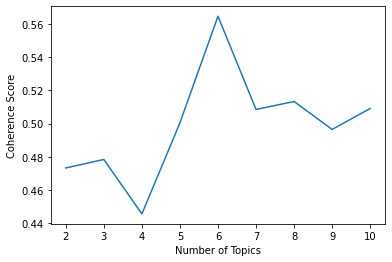

In [68]:
coherence_scores_review = []
num_topics_range = range(2, 11)

for i in num_topics_range:
    lsi = LsiModel(bow_review, num_topics=i, id2word=dictionary_review)
    coherence_model = CoherenceModel(model=lsi, texts=corpus_review, dictionary=dictionary_review, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores_review.append(coherence_score)
    
    print('Coherence score with {} clusters: {}'.format(i, coherence_score))

plt.plot(num_topics_range, coherence_scores_review)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show()

In [69]:
lsi_review = LsiModel(bow_review, num_topics=6, id2word=dictionary_review)

In [70]:
topic_data_review = []

for topic_num, words in lsi_review.print_topics(num_words=5):
    topic_words_review = [word.split('*')[1].strip() for word in words.split(' + ')]
    topic_coefs_review = [float(word.split('*')[0]) for word in words.split(' + ')]
    sorted_topic_review = sorted(zip(topic_words_review, topic_coefs_review), key=lambda x: x[1], reverse=True)
    sorted_topic_words_review, sorted_topic_coefs_review = zip(*sorted_topic_review)
    topic_data_review.append({'Topic': topic_num, 'Words': sorted_topic_words_review, 'Coefficients': sorted_topic_coefs_review})


review_filter = pd.DataFrame(topic_data_review)
review_filter

,Topic,Words,Coefficients
0,0,"(""항상"", ""사장"", ""친절"", ""컨지션"", ""이용"")","(0.579, 0.497, 0.391, 0.39, 0.194)"
1,1,"(""이용"", ""객실"", ""컨디션"", ""친절"", ""사장"")","(0.494, 0.462, 0.452, -0.236, -0.393)"
2,2,"(""방이"", ""사장"", ""항상"", ""친절"", ""컨지션"")","(0.719, 0.444, -0.202, -0.31, -0.31)"
3,3,"(""방이"", ""사장"", ""친절"", ""장판"", ""청결"")","(0.028, 0.015, -0.011, -0.703, -0.711)"
4,4,"(""방이"", ""가격"", ""전주"", ""숙소"", ""정말"")","(0.051, -0.064, -0.078, -0.104, -0.963)"
5,5,"(""정말"", ""숙소"", ""전주"", ""가격"", ""이용"")","(0.258, -0.253, -0.272, -0.298, -0.312)"


# 평점 상위 20개, 하위 20개 숙소 토픽 모델링

In [71]:
# 리뷰개수 10개 이상의 숙소에 대해 평점 평균 비교
star_counts = df.groupby('hotel').agg({'review clean': 'count', 'star': 'mean'})
star_counts = star_counts[(star_counts['review clean'] >= 10)]
star_counts = star_counts.sort_values(by='star', ascending=False)
star_counts

,review clean,star
hotel,,
전주 웨이,12,10.000000
전주 꽃자리펜션(무료조식제공),10,10.000000
전주 한옥마을숙박 꿈 한옥스테이,15,10.000000
전주 별빛궁한옥펜션,14,10.000000
전주 한옥마을풍남주택펜션,14,10.000000
...,...,...
전주 동산동 편백,52,6.500000
전주 중화산동 화려한외출Ⅱ,66,6.272727
전주 금암동 스카이쇼1 무인텔,22,6.090909


In [72]:
star_counts['star'].head(20)

hotel
전주 웨이                              10.000000
전주 꽃자리펜션(무료조식제공)                   10.000000
전주 한옥마을숙박 꿈 한옥스테이                  10.000000
전주 별빛궁한옥펜션                         10.000000
전주 한옥마을풍남주택펜션                      10.000000
전주 별빛궁 한옥스테이                       10.000000
전주 별자리 한옥스테이                        9.935484
전주 중화산동 호텔 시그니처 (Signature)         9.921053
전주 전주한옥마을웨이펜션                       9.894737
전주 서신동 투썸스테이                        9.894737
전주 한옥마을삼락헌한옥펜션                      9.893617
전주한옥마을 게스트하우스                       9.882609
전주 서선야 한옥스테이                        9.882353
전주 산정동 에이치에비뉴(H Avenue) 전주아중지구점     9.859155
전주 우아동 브라운도트 전주아중지구점                9.857143
전주 한옥마을어사화펜션                        9.857143
전주 한옥미담 스테이                         9.854167
전주 더머뭄 한옥스테이                        9.850000
전주 갤러리스테이                           9.836735
전주 서로한옥펜션                           9.833333
Name: star, dtype: float64

In [73]:
star_counts['star'].tail(20)

hotel
전주 덕진동 W                               7.696970
전주 이화원고택한옥펜션                           7.600000
전주 중화산동 호텔 스타(hotel star)              7.566667
전주 금암동 타임                              7.479775
전주관광호텔                                 7.432836
전주 신시가지 호텔 아이                          7.377049
전주 중화산동 조아                             7.343284
전주 금암동 로즈마리                            7.309589
전주 로니관광호텔                              7.272727
전주 블루보트 게스트하우스                         7.200000
전주 덕진동 핀앤핏하우스                          7.117647
전주 중화산동 자유세상                           7.090909
전주 엑스오 XO 호텔                           6.857143
전주 신시가지 씨투                             6.852459
전주 우아동 아미르                             6.612088
전주 동산동 편백                              6.500000
전주 중화산동 화려한외출Ⅱ                         6.272727
전주 금암동 스카이쇼1 무인텔                       6.090909
전주 중화산동 포레 호텔                          6.000000
전주 산정동 짬 (Jeonju Sanjeongdong Zzam)    5.771429
Name: star, dtype: float64

In [74]:
#상위 20개 숙소
head_hotel_list = star_counts.index.tolist()[:20]
head_hotel = df[df['hotel'].isin(head_hotel_list)]
head_hotel

,hotel,star,review,real_date,review clean
861,전주 웨이,10.0,첫번째로 사장님 너무 친절해서 기분이 좋았어요 방도 아기자기하고 깔끔하고 딱 좋았습...,20230328,사장 기분 방도 위치 마을 산책 야경 구경 길거리 음식 방문 의사 추천 사장 숙소 ...
862,전주 웨이,10.0,한옥마을 안에있어서 한옥마을을 좀더 길게 즐길수 있었어요 숙소도 엄청 깔끔했어요 ㅎ...,20230124,마을 마을 좀더 숙소 인형 옥뷰 최고 커피 한잔 서비스 주시 사장 방문 의사
863,전주 웨이,10.0,한옥마을 메인길 초입에 있어서 굉장히 편합니다숙소 내부 청소 잘되어있어요 사장님도 ...,20221004,마을 메인 초입 숙소 내부 청소 사장 아주 옥상 테라스 한번 보시 숙소 위치 마을 ...
865,전주 웨이,10.0,사장님이 정말 친절하게 맞이해주셔서 기분이 너무 좋았어요 ㅎㅎ 숙소 위치도 한옥마을...,20230219,사장 정말 맞이 기분 숙소 위치 마을 중심 할리스커피 할인 방도 탁상 거울 구비
866,전주 웨이,10.0,한옥 마을 내에 차도 주차하고 구경할 수 있을 뿐 아니라 숙소도 청결하고 방에 화장...,20230218,마을 차도 주차 구경 숙소 화장실 사장 아침 커피 할인 저희 다음 여행 여기 숙소 ...
...,...,...,...,...,...
22484,전주한옥마을 게스트하우스,9.3,늦은 시간에 문자 보내도 친절히 답변해주시고방도 따뜻해서 잘 쉬고 가요그런데 저희 ...,20230304,시간 문자 답변 방도 가요 저희 당황 물건 고장 부분 해결
22485,전주한옥마을 게스트하우스,10.0,청결하고 딱 혼자 묵기 좋아요월의 방온돌 뜨끈뜨끈하고 화장실 딸려있는 게 정말 좋았...,20230304,혼자 온돌 화장실 정말
22486,전주한옥마을 게스트하우스,10.0,이 숙소 찾은 게 이번 전주 여행의 개이득인 거 같습니다한옥마을 오면 항상 숙박은 ...,20230204,숙소 이번 전주 여행 개이득 마을 항상 숙박 도전 만족 방도 모델링 벽지 화장실 겨...
22487,전주한옥마을 게스트하우스,10.0,사장님이 친절하고 생각보다 따뜻해요 월의 방 인실이긴한데 명도 가능할거 같아요침대는...,20230204,사장 생각 명도 침대 아침 일어나서 화장실 가면 화장실 춥다 단점 가격 느낌 가성 ...


In [75]:
corpus_headstar = head_hotel['review clean'].str.split()
dictionary_headstar = corpora.Dictionary(corpus_headstar)
bow_headstar = [dictionary_headstar.doc2bow(text) for text in corpus_headstar]

Coherence score with 2 clusters: 0.5440368345192875
Coherence score with 3 clusters: 0.4665397964437637
Coherence score with 4 clusters: 0.5655011919572337
Coherence score with 5 clusters: 0.5830899332193568
Coherence score with 6 clusters: 0.5802194624464828
Coherence score with 7 clusters: 0.5003070973711807
Coherence score with 8 clusters: 0.5493071726116159
Coherence score with 9 clusters: 0.5604786798454185
Coherence score with 10 clusters: 0.484673345553391


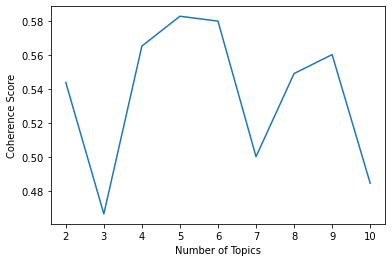

In [76]:
coherence_scores_headstar = []
num_topics_range = range(2, 11)

for i in num_topics_range:
    lsi = LsiModel(bow_headstar, num_topics=i, id2word=dictionary_headstar)
    coherence_model = CoherenceModel(model=lsi, texts=corpus_headstar, dictionary=dictionary_headstar, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores_headstar.append(coherence_score)
    
    print('Coherence score with {} clusters: {}'.format(i, coherence_score))

plt.plot(num_topics_range, coherence_scores_headstar)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show()

In [77]:
lsi_headstar= LsiModel(bow_headstar, num_topics=5, id2word=dictionary_headstar)  

In [79]:
topic_data_headstar = []

for topic_num, words in lsi_headstar.print_topics(num_words=5):
    topic_words_headstar = [word.split('*')[1].strip() for word in words.split(' + ')]
    topic_coefs_headstar = [float(word.split('*')[0]) for word in words.split(' + ')]
    sorted_topic_headstar = sorted(zip(topic_words_headstar, topic_coefs_headstar), key=lambda x: x[1], reverse=True)
    sorted_topic_words_headstar, sorted_topic_coefs_headstar = zip(*sorted_topic_headstar)
    topic_data_headstar.append({'headstar Words': sorted_topic_words_headstar, 'headstar Coefficients': sorted_topic_coefs_headstar})


review_headstar = pd.DataFrame(topic_data_headstar)
review_headstar

,headstar Words,headstar Coefficients
0,"(""사장"", ""숙소"", ""마을"", ""보기"", ""정말"")","(0.534, 0.463, 0.24, 0.201, 0.194)"
1,"(""숙소"", ""정도"", ""진짜"", ""정말"", ""사장"")","(0.718, 0.112, -0.072, -0.205, -0.539)"
2,"(""사장"", ""숙소"", ""마을"", ""이용"", ""정말"")","(0.476, 0.325, -0.167, -0.22, -0.338)"
3,"(""정말"", ""숙소"", ""전주"", ""방문"", ""마을"")","(0.587, 0.205, -0.187, -0.258, -0.41)"
4,"(""정도"", ""시간"", ""사장"", ""전주"", ""정말"")","(0.332, 0.258, 0.23, -0.208, -0.378)"


In [80]:
#평점 하위 20개 숙소
tail_hotel_list = star_counts.index.tolist()[-20:]
tail_hotel = df[df['hotel'].isin(tail_hotel_list)]
tail_hotel

,hotel,star,review,real_date,review clean
12,전주 산정동 짬 (Jeonju Sanjeongdong Zzam),7.6,숙소가 크고 깨그해서 좋았지만 화장실과샤워부스문이 보이는 유리문이라 약간 민망할수있어요,20230527,숙소 화장실 샤워 부스 유리 약간
13,전주 산정동 짬 (Jeonju Sanjeongdong Zzam),4.8,바닥에 체모와 세면대가 없고 변기와 샤워실이 따로 있던 게 영 불편함,20230506,바닥 체모 세면대 변기 샤워실
14,전주 산정동 짬 (Jeonju Sanjeongdong Zzam),5.6,가격 대비 지내고 갈만합니다 담배냄새만 감수하시면 됩니다,20230504,가격 대비 담배 냄새 감수
15,전주 산정동 짬 (Jeonju Sanjeongdong Zzam),7.2,세면대가 없어서 너무 불편했어요ㅠㅠㅠ후기보고 세면대 없어도 샤워할때 씻자했는데 막상...,20230407,세면대 후기 보고 세면대 샤워 막상 쓰레기통 진짜 모텔 특유 인테리어
16,전주 산정동 짬 (Jeonju Sanjeongdong Zzam),3.2,방음이 도 안되요 위 옆 아래에서 걷는소리 까지 다 나요,20230406,방음 아래 소리
...,...,...,...,...,...
22175,전주 금암동 로즈마리,10.0,시설이 청결하고 넓고 좋네요,20200604,시설
22176,전주 금암동 로즈마리,8.0,탁자가없어서 그게좀 아쉬웠음,20200604,탁자 그게
22178,전주 금암동 로즈마리,6.0,시설 그럭저럭하구 잘 쉬다갑니다,20200604,시설
22179,전주 금암동 로즈마리,6.0,가성비ㅎㅎ자취방같아여,20200604,가성 자취


In [81]:
corpus_tailstar = tail_hotel['review clean'].str.split()
dictionary_tailstar = corpora.Dictionary(corpus_tailstar)
bow_tailstar = [dictionary_tailstar.doc2bow(text) for text in corpus_tailstar]

Coherence score with 2 clusters: 0.5239063514733446
Coherence score with 3 clusters: 0.5962047490260894
Coherence score with 4 clusters: 0.6110012759936752
Coherence score with 5 clusters: 0.5372217618909815
Coherence score with 6 clusters: 0.5316840819731464
Coherence score with 7 clusters: 0.668827990203108
Coherence score with 8 clusters: 0.6024691000129017
Coherence score with 9 clusters: 0.6149373533583669
Coherence score with 10 clusters: 0.5967325783918016


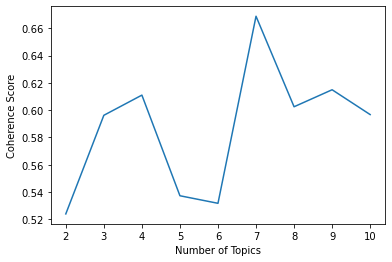

In [82]:
coherence_scores_tailstar = []
num_topics_range = range(2, 11)

for i in num_topics_range:
    lsi = LsiModel(bow_tailstar, num_topics=i, id2word=dictionary_tailstar)
    coherence_model = CoherenceModel(model=lsi, texts=corpus_tailstar, dictionary=dictionary_tailstar, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores_tailstar.append(coherence_score)
    
    print('Coherence score with {} clusters: {}'.format(i, coherence_score))

plt.plot(num_topics_range, coherence_scores_tailstar)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show()

In [83]:
lsi_tailstar= LsiModel(bow_tailstar, num_topics=7, id2word=dictionary_tailstar)

In [84]:
topic_data_tailstar = []

for topic_num, words in lsi_tailstar.print_topics(num_words=5):
    topic_words_tailstar = [word.split('*')[1].strip() for word in words.split(' + ')]
    topic_coefs_tailstar = [float(word.split('*')[0]) for word in words.split(' + ')]
    sorted_topic_tailstar = sorted(zip(topic_words_tailstar, topic_coefs_tailstar), key=lambda x: x[1], reverse=True)
    sorted_topic_words_tailstar, sorted_topic_coefs_tailstar = zip(*sorted_topic_tailstar)
    topic_data_tailstar.append({'tailstar Words': sorted_topic_words_tailstar, 'tailstar Coefficients': sorted_topic_coefs_tailstar})


review_tailstar = pd.DataFrame(topic_data_tailstar)
review_tailstar

,tailstar Words,tailstar Coefficients
0,"(""수압"", ""아주"", ""전화"", ""혼자"", ""요조"")","(-0.0, 0.0, 0.0, 0.0, -1.0)"
1,"(""수건"", ""지원이"", ""휠씐"", ""넷플릭스"", ""요요"")","(-0.0, -0.001, -0.001, -0.038, -0.999)"
2,"(""최악"", ""예약"", ""시간"", ""보기"", ""화장실"")","(0.379, 0.213, 0.201, 0.188, 0.174)"
3,"(""카운터"", ""시간"", ""예약"", ""완전"", ""최악"")","(0.115, 0.113, 0.106, -0.348, -0.815)"
4,"(""시간"", ""객실"", ""가격"", ""냄새"", ""화장실"")","(0.207, -0.182, -0.26, -0.282, -0.39)"
5,"(""가격"", ""대비"", ""시설"", ""생각"", ""카운터"")","(0.51, 0.207, 0.18, 0.167, -0.172)"
6,"(""바퀴벌레"", ""생각"", ""대비"", ""방문"", ""가격"")","(0.179, 0.174, -0.221, -0.227, -0.502)"


In [85]:
df_star = pd.concat([review_headstar,review_tailstar],axis=1)
df_star

,headstar Words,headstar Coefficients,tailstar Words,tailstar Coefficients
0,"(""사장"", ""숙소"", ""마을"", ""보기"", ""정말"")","(0.534, 0.463, 0.24, 0.201, 0.194)","(""수압"", ""아주"", ""전화"", ""혼자"", ""요조"")","(-0.0, 0.0, 0.0, 0.0, -1.0)"
1,"(""숙소"", ""정도"", ""진짜"", ""정말"", ""사장"")","(0.718, 0.112, -0.072, -0.205, -0.539)","(""수건"", ""지원이"", ""휠씐"", ""넷플릭스"", ""요요"")","(-0.0, -0.001, -0.001, -0.038, -0.999)"
2,"(""사장"", ""숙소"", ""마을"", ""이용"", ""정말"")","(0.476, 0.325, -0.167, -0.22, -0.338)","(""최악"", ""예약"", ""시간"", ""보기"", ""화장실"")","(0.379, 0.213, 0.201, 0.188, 0.174)"
3,"(""정말"", ""숙소"", ""전주"", ""방문"", ""마을"")","(0.587, 0.205, -0.187, -0.258, -0.41)","(""카운터"", ""시간"", ""예약"", ""완전"", ""최악"")","(0.115, 0.113, 0.106, -0.348, -0.815)"
4,"(""정도"", ""시간"", ""사장"", ""전주"", ""정말"")","(0.332, 0.258, 0.23, -0.208, -0.378)","(""시간"", ""객실"", ""가격"", ""냄새"", ""화장실"")","(0.207, -0.182, -0.26, -0.282, -0.39)"
5,NaN,NaN,"(""가격"", ""대비"", ""시설"", ""생각"", ""카운터"")","(0.51, 0.207, 0.18, 0.167, -0.172)"
6,NaN,NaN,"(""바퀴벌레"", ""생각"", ""대비"", ""방문"", ""가격"")","(0.179, 0.174, -0.221, -0.227, -0.502)"
